In [9]:
import numpy as np
import hist
import matplotlib.pyplot as plt
from scipy.integrate import quad
import os

Initialize the $m_{\mu\mu}$ hist

In [10]:
nbin = 100
minvmin = 1.5
minvmax = 5
hminv = hist.Hist(hist.axis.Regular(bins=nbin,start=minvmin,stop=minvmax))

f = open('minv_CMUL.npy', 'rb')
for i in range(166):
    A = np.load(f)
    #print(A)
    hminv.fill(A)
f.close()

Fit functions definitions

In [11]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def bgVWG(x, N, mu, alpha, beta):
    X = (x-mu)/mu
    sig = alpha + beta*X
    return N*np.exp(-(x-mu)**2/(2*sig**2))

def bgPL(x, N, mu, a1, a2, a3):
    return N*(1+a1*x)/(a2*x+a3*x)
    #return N*(a1*x**2+a2*x+a3)  # test
    
def bgDE(x, N, a1, a2, a3):
    return N*(np.exp(a1*x) + a3*np.exp(a2*x))


def crystalball(x, N, mu, sig, alphaL, nL, alphaR, nR):
    AL = ( nL / np.absolute( alphaL ) )**nL * np.exp( -1 * np.absolute( alphaL )**2 / 2 )
    AR = ( nR / np.absolute( alphaR ) )**nR * np.exp( -1 * np.absolute( alphaR )**2 / 2 )
    BL = nL / np.absolute( alphaL ) - np.absolute( alphaL )
    BR = nR / np.absolute( alphaR ) - np.absolute( alphaR )

    result = np.zeros(np.shape(x))
    
    rel = ( x - mu )/sig
    I1 = rel < -1 * alphaL
    I2 = (rel >= -1 * alphaL) * (rel <= alphaR)
    I3 = rel > alphaR
    result[I1] = AL * (BL - rel[I1])**(-nL)
    result[I2] = np.exp(-1 * rel[I2]**2 / 2)
    result[I3] = AR*(BR + rel[I3])**(-nR)
        
    return result * N #/ (np.sqrt(2 * np.pi) * sig)

def fitfunc(x,
            N1, mu1, sig1, alphaL1, nL1, alphaR1, nR1,
            N2, mu2, sig2, alphaL2, nL2, alphaR2, nR2,
            Nbg, a1, a2, a3):
    return 1*crystalball(x, N1, mu1, sig1, alphaL1, nL1, alphaR1, nR1) \
        + 1*crystalball(x, N2, mu2, sig2, alphaL2, nL2, alphaR2, nR2) \
        + bgVWG(x, Nbg, a1, a2, a3)


Get x,y data from the histogram for the fit

In [12]:
# Fit minv interval
xmin = minvmin
xmax = minvmax
# Get data from histo
y,x = hminv[xmin*1j:xmax*1j].to_numpy()
x = x[:-1]+(x[1]-x[0])/2
xminpeak = 2.3
xmaxpeak = 4.0

# Fit the background in order to get initial parameters ($p_0$) for the final fit

bg params:  [11.87582659  1.04176339  1.5776013   0.69047636]


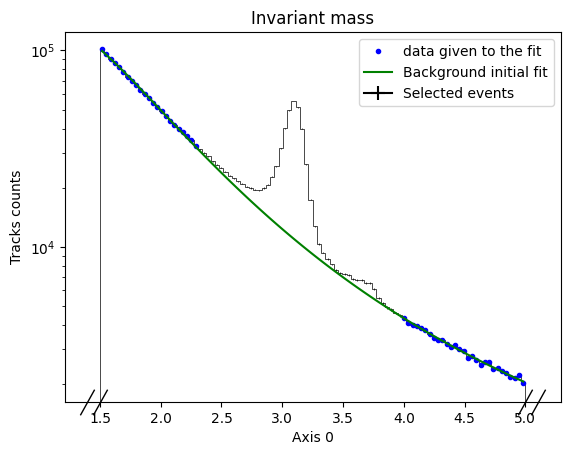

In [13]:
# remove peaks from data in order to fit the background only
Ipeaks = (xminpeak<x)*(x<xmaxpeak)
Ibg = ~Ipeaks
paramsbg, covsbg = curve_fit(bgVWG, x[Ibg], np.log(y[Ibg]), method='trf')

print("bg params: ", paramsbg) 

# Plot
hminv.plot(label="Selected events",color='black',ls='-',lw=0.5)
plt.plot(x[Ibg],y[Ibg],'.b',label="data given to the fit")
yfitbg = np.exp(bgVWG(x,*paramsbg))
plt.plot(x,yfitbg,'g',label="Background initial fit")
plt.yscale("log")
plt.ylabel("Tracks counts")
plt.title('Invariant mass');
plt.legend();

# Final fit (background + two crystal balls)

/tmp/ipykernel_197/2089975146.py:20: RuntimeWarning: invalid value encountered in scalar power
  AR = ( nR / np.absolute( alphaR ) )**nR * np.exp( -1 * np.absolute( alphaR )**2 / 2 )
/tmp/ipykernel_197/2089975146.py:32: RuntimeWarning: invalid value encountered in power
  result[I3] = AR*(BR + rel[I3])**(-nR)


fit params:  [1.62501475e+00 3.09975331e+00 9.78048601e-02 8.67133288e-01
 5.26250098e+00 2.03837934e+00 2.40336623e+00 1.28121952e-01
 3.69036582e+00 7.81037782e-02 8.08941732e+01 1.95306738e+01
 2.27456697e+01 1.87297055e+01 1.20832851e+01 8.70779696e-01
 1.67134238e+00 5.52381085e-01]
fit sigmas: 
 [2.65102876e-04 3.89790831e-07 1.55198289e-06 1.07233995e-03
 4.31388229e+00 1.56153928e-01 2.12270538e+01 3.85995574e-04
 1.77405786e-04 2.61176605e-04 2.06772506e-29 8.00248761e-30
 1.07554501e-58 1.15534146e-32 1.64452339e-02 1.16853593e-02
 5.44571916e-03 7.37924832e-03]


<Figure size 640x480 with 0 Axes>

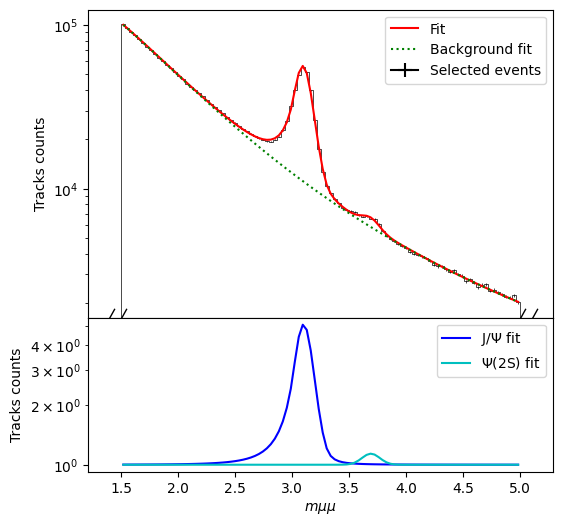

In [21]:
#p0 = [1000, 3.1, 0.09, 10, 3, 1, 3, *paramsbg]
# initial parameters
#p0bg = np.array([12.24388984, 0.79910836, 1.70955885, 0.49997999])
p0bg = np.array(paramsbg)
p0JPsi = np.array([1, 3.09971779,  0.09721581,  0.86657034,  5.08994489,  2.05325712,  2.27110378])
p0Psi2S = np.array([1,  3.68838506,  0.07972319, 18.94980262,  3.81455163, 21.81429016, 18.83400848])
# bounds
varbg = np.array([1, 1, 1, 1])*20 # bg parameters variation around p0 in %
varp = np.array([np.inf, 5, 20, np.inf, np.inf, np.inf, np.inf])  # peaks parameters variation around p0 in %
bounds = ([*p0JPsi*(1-varp/100), *p0Psi2S*(1-varp/100), *p0bg*(1-varbg/100)],
          [*p0JPsi*(1+varp/100), *p0Psi2S*(1+varp/100), *p0bg*(1+varbg/100)])
for i in (0,7,14):
    bounds[0][i] = 0  # N>0
#print(bounds)

# Fit all
params, covs = curve_fit(fitfunc, x, np.log(y),
                         sigma=np.sqrt(y)/y,
                         p0=[*p0JPsi, *p0Psi2S, *p0bg],
                         bounds=bounds,
                         method='trf')

print("fit params: ", params) 
print("fit sigmas: \n", np.diag(covs))

plt.clf()
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True,figsize=(6,6), gridspec_kw={'height_ratios': [2,1]})

# Plot data
hminv.plot(ax=ax1,label="Selected events",color='black',ls='-',lw=0.5)
yfit = fitfunc(x,*params)
# Plot fit
ax1.plot(x,np.exp(yfit),'-r',label="Fit")
# Plot fit error
sigmas = np.diag(covs)**2
errfit = np.sqrt(np.sum(sigmas))
#ax1.fill_between(x,np.exp(yfit-errfit),np.exp(yfit+errfit),color='red',alpha=0.1)  

# Plot p0
if 0:
    ax1.plot(x,np.exp(bgVWG(x,*p0bg)),':g',label="Initial background")
    ax1.plot(x,np.exp(crystalball(x,*p0JPsi)),':b',label="Initial J/Psi Crystall Ball function")    
    ax1.plot(x,np.exp(crystalball(x,*p0Psi2S)),':c',label="Initial $Psi$(2S) Crystall Ball function")  


ax1.plot(x,np.exp(bgVWG(x,*params[-4:])),':g',label="Background fit")  


# Plot crystal ball functions
yfitJPsi = crystalball(x,*params[:7])
yfitPsi2S = crystalball(x,*params[7:14])
ax2.plot(x,np.exp(yfitJPsi),'-b',label="J/$\Psi$ fit")     
ax2.plot(x,np.exp(yfitPsi2S),'-c',label="$\Psi$(2S) fit")  
# Errors of crystal ball functions
errfitJPsi = np.sqrt(np.sum(sigmas[:7]))
errfitJPsi = np.sqrt(np.sum(sigmas[7:14]))
#ax2.fill_between(x,np.exp(yfitJPsi-1),np.exp(yfitJPsi+1),color='blue',alpha=0.2)

for ax in (ax1,ax2):
    ax.set_yscale("log")
    ax.set_xlabel('$m\mu\mu$')
    ax.set_ylabel("Tracks counts")
    ax.legend()
fig.subplots_adjust(hspace=0)

In [15]:
# Integrate
I_JPsi = quad(crystalball, 0, 10, args=tuple(params[:7]))
print("JPsi integral:",I_JPsi)

JPsi integral: (0.5268112265332014, 3.1514379967867245e-09)
